# Generate example plots for EGU 2021

This notebook creates the example figures for the [EGU 2021 presentation on Harmonica and Boule](https://github.com/fatiando/egu2021). The Harmonica example is based on the [Transform 2021 tutorial](https://github.com/fatiando/transform21) code.

In [1]:
import numpy as np
import xarray as xr
import pyproj
import verde as vd
import pygmt
import pooch
import boule as bl
import harmonica as hm

## Harmonica

Load our sample Southern Africa dataset to use as an example.

In [2]:
data = hm.datasets.fetch_south_africa_gravity()
# Cut the data to smaller region
region = (25, 32, -27, -24)
inside = vd.inside((data.longitude, data.latitude), region)
data = data[inside]
data

,latitude,longitude,elevation,gravity
8848,-26.26334,25.01500,1230.16,978681.38
8849,-26.38713,25.01932,1297.00,978669.02
8850,-26.39667,25.02499,1304.84,978669.28
8851,-26.07668,25.04500,1165.24,978681.08
8852,-26.35001,25.07668,1262.47,978665.19
...,...,...,...,...
11973,-24.70000,31.80833,288.34,978849.23
11974,-24.24500,31.84500,253.90,978850.43
11975,-24.14333,31.84500,263.95,978852.83
11976,-24.78833,31.86166,247.19,978884.52


Make a plot of the raw gravity data.

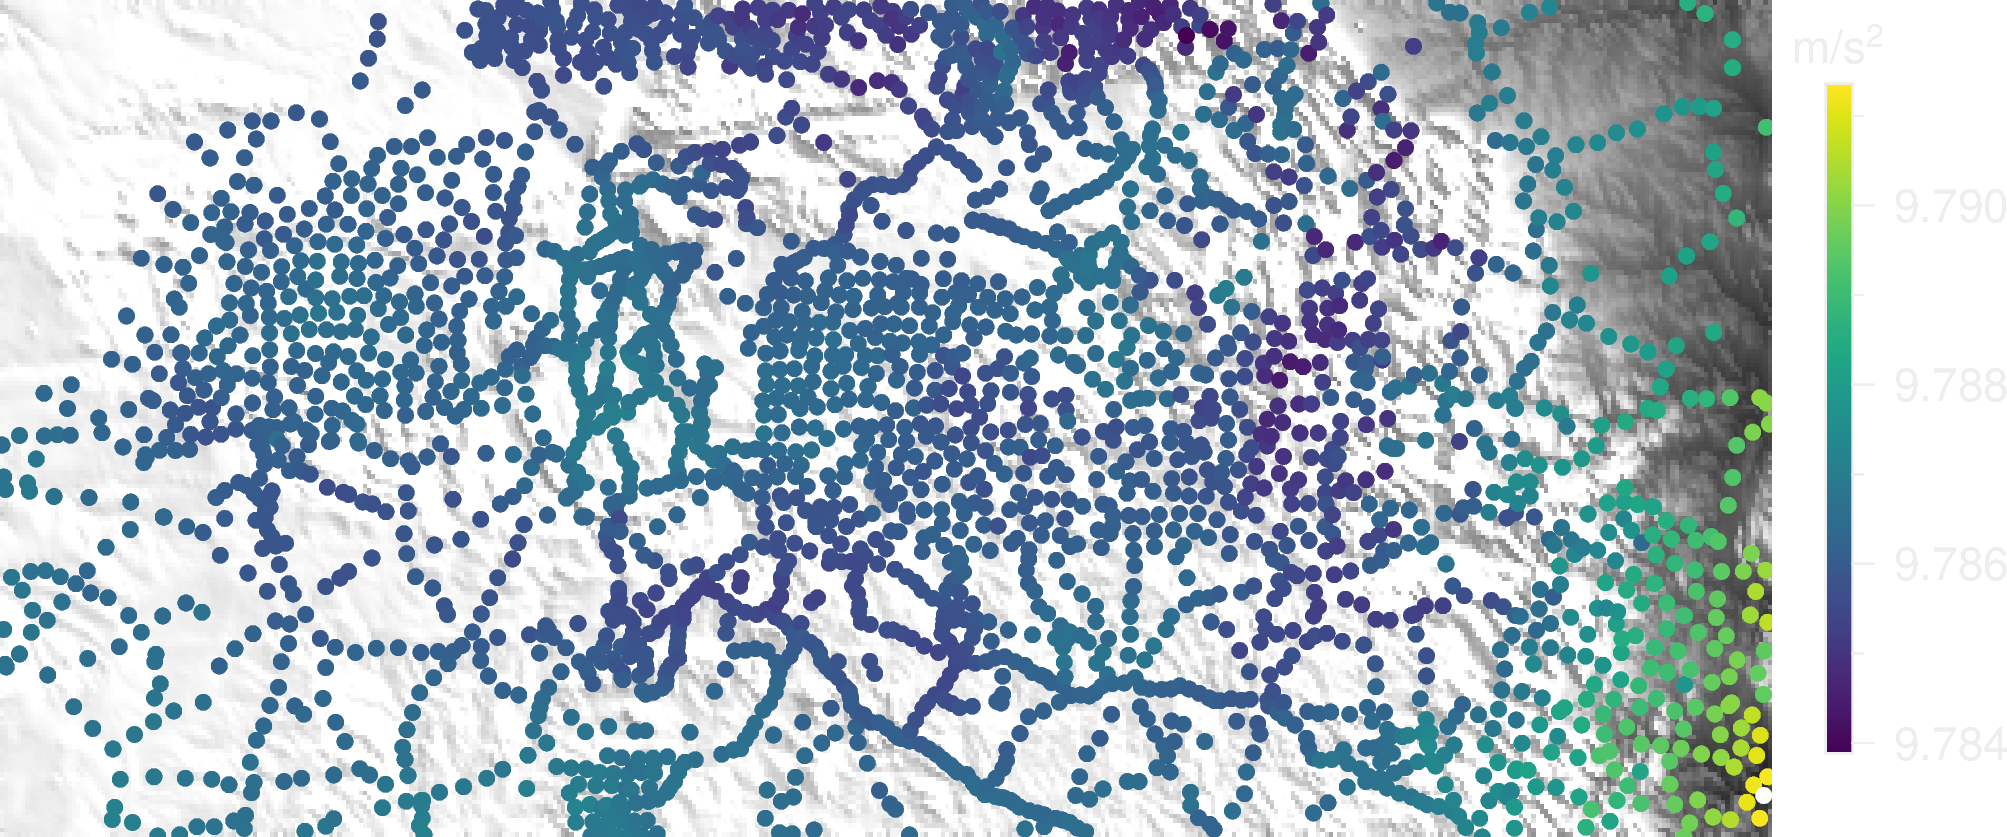

In [3]:
color = "#eeeeee"
pygmt.config(
    FONT_ANNOT=f"11p,Helvetica,{color}",
    FONT_TITLE=f"13p,Helvetica,{color}",
    FONT_LABEL=f"11p,Helvetica,{color}",
    MAP_FRAME_TYPE="plain",
    MAP_FRAME_PEN=f"0.5p,{color}",    
    MAP_TICK_PEN=f"{color}",
)

# Plot the observerd gravity using pygmt
fig = pygmt.Figure()
pygmt.makecpt(cmap="gray", series=[0, 800])
fig.grdimage(
    "@earth_relief_01m",
    region=region,
    projection="M15c",
    shading="+a45+nt0.7",
    cmap=True,
)
pygmt.makecpt(
    cmap="viridis", 
    series=[data.gravity.min() * 1e-5, data.gravity.max() * 1e-5]
)
fig.plot(
    x=data.longitude, 
    y=data.latitude, 
    color=data.gravity * 1e-5, 
    cmap=True, 
    style="c4p", 
)
#fig.basemap(frame=["af", 'WeSn'])
fig.colorbar(position="JRM+v", frame=["af", 'y+l"m/s@+2@+"'])
fig.savefig("images/bushveld-points.png", transparent=True)
fig.show()

Project the data to Mercator.

In [4]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
# Project the dataset coordinates:
data["easting"], data["northing"] = projection(data.longitude.values, data.latitude.values)
coordinates = (data.easting, data.northing, data.elevation)

Load a DEM of topography for this region and project it as well.

In [5]:
fname = pooch.retrieve(
    url="https://github.com/fatiando/transform21/raw/main/data/bushveld_topography.nc", 
    known_hash="sha256:7eafc98d1be83daa355ed3d71fe9fa735cc86aea20b8bcecf1fce60c1530a50a", 
)
topography = vd.project_grid(xr.load_dataset(fname).bedrock, projection=projection, method="nearest")
topography

<xarray.DataArray 'bedrock' (northing: 240, easting: 419)>
array([[1257.  , 1260.  , 1266.  , ...,  198.  ,  198.  ,  425.  ],
       [1245.  , 1254.  , 1261.  , ...,  210.5 ,  210.5 ,  375.  ],
       [1256.  , 1258.  , 1268.  , ...,  216.  ,  216.  ,  300.  ],
       ...,
       [1029.  , 1031.  , 1033.  , ...,  245.  ,  245.  ,  238.  ],
       [1028.5 , 1030.5 , 1032.5 , ...,  244.25,  244.25,  237.5 ],
       [    nan,     nan,     nan, ...,  244.25,  244.25,  237.5 ]])
Coordinates:
  * easting   (easting) float64 2.515e+06 2.517e+06 ... 3.214e+06 3.215e+06
  * northing  (northing) float64 -2.803e+06 -2.802e+06 ... -2.366e+06 -2.364e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

Calculate the gravity disturbance using Boule.

In [6]:
data["gravity_disturbance"] = data.gravity - bl.WGS84.normal_gravity(data.latitude, data.elevation)

Model the effect of topography with prisms. The modelling is done in parallel automatically.

In [7]:
model = hm.prism_layer(
    coordinates=(topography.easting, topography.northing),
    surface=topography.values,
    reference=0,
    properties={"density": 2670 * np.ones(topography.shape)},
)
topographic_effect = model.prism_layer.gravity(coordinates, field="g_z")

Calculate the Bouguer disturbance.

In [8]:
data["gravity_bouguer"] = data.gravity_disturbance - topographic_effect

Remove a 2nd order trend to calculate residuals.

In [9]:
trend = vd.Trend(degree=2).fit(coordinates, data.gravity_bouguer)
data["gravity_residual"] = data.gravity_bouguer - trend.predict(coordinates)

Grid the residuals at a constant height of 2200 m with an equivalent source method. The grid is generated in geographic coordinates with a spacing of 0.01 degrees (using the original projection).

In [10]:
eql = hm.EQLHarmonic(damping=1, relative_depth=15e3).fit(coordinates, data.gravity_residual)
grid = eql.grid(
    upward=2200,
    region=region,
    spacing=0.01,
    data_names=["gravity_residual"],
    dims=("latitude", "longitude"),
    projection=projection,
)
grid

<xarray.Dataset>
Dimensions:           (latitude: 301, longitude: 701)
Coordinates:
  * longitude         (longitude) float64 25.0 25.01 25.02 ... 31.98 31.99 32.0
  * latitude          (latitude) float64 -27.0 -26.99 -26.98 ... -24.01 -24.0
    upward            (latitude, longitude) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    gravity_residual  (latitude, longitude) float64 5.164 5.205 ... 53.72 52.85
Attributes:
    metadata:  Generated by EQLHarmonic(damping=1, relative_depth=15000.0)

Plot the gridded residuals.

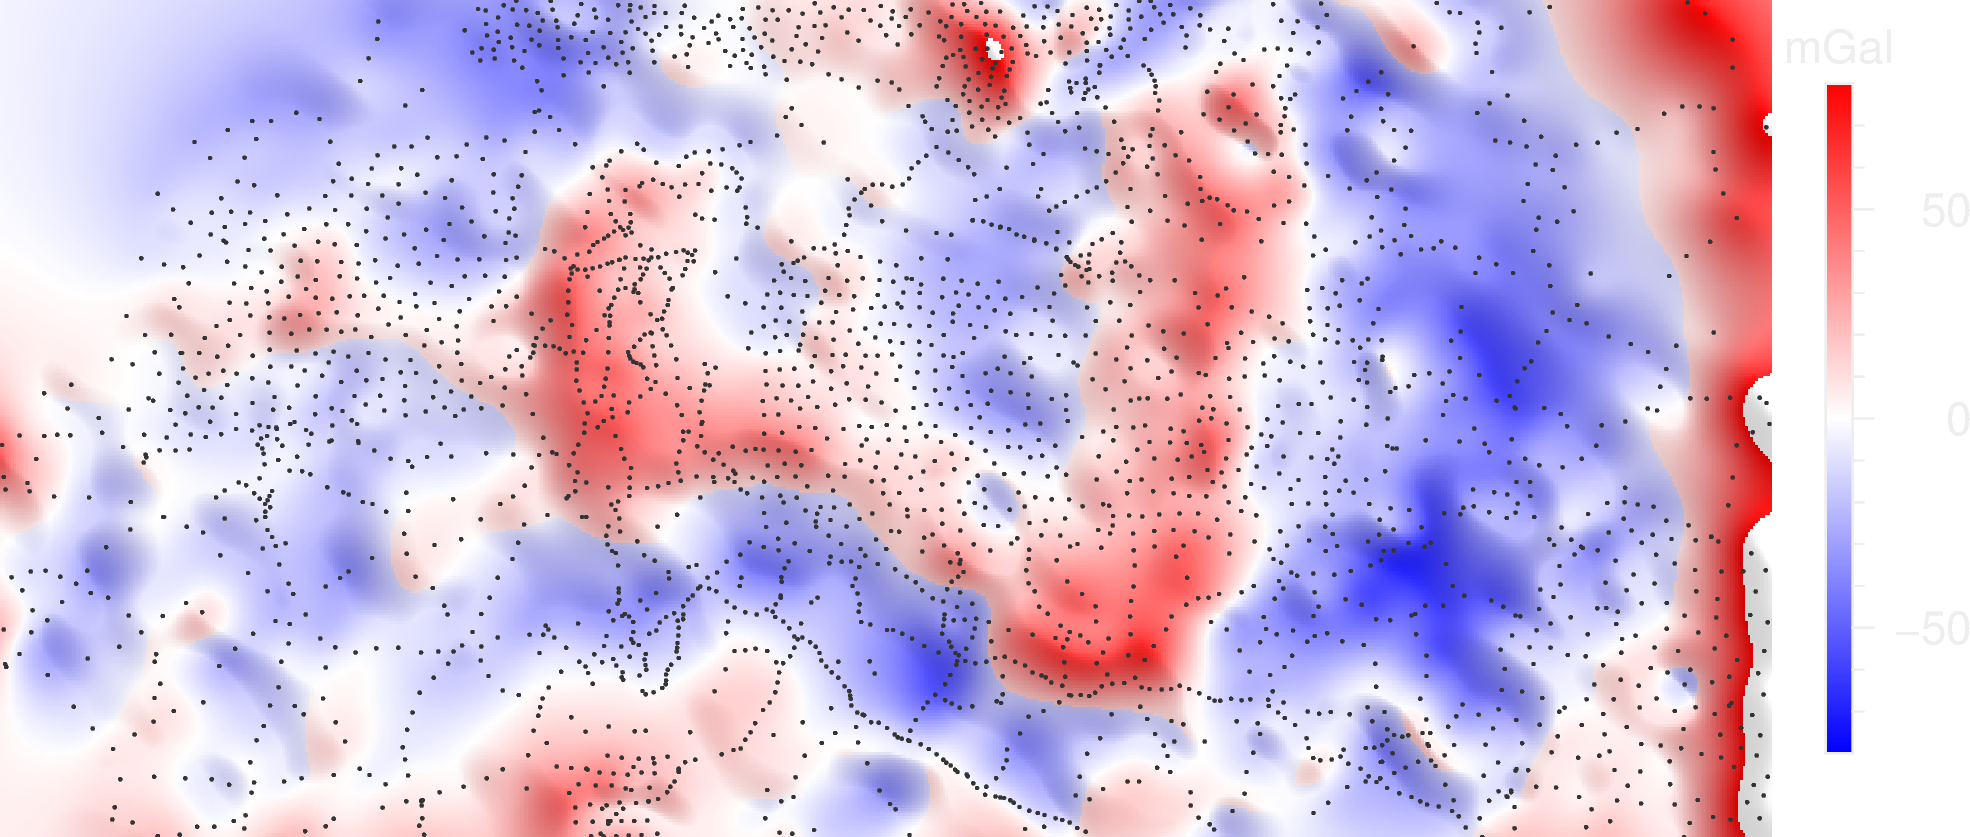

In [11]:
scale = vd.maxabs(grid.gravity_residual.values) * 0.7
fig = pygmt.Figure()
pygmt.makecpt(
    cmap="polar", 
    series=[-scale, scale],
    no_bg=True,
)
fig.grdimage(
    grid.gravity_residual,
    region=region,
    projection="M15c",
    shading="+a45+nt0.3",
    cmap=True,
)
fig.plot(
    x=data.longitude, 
    y=data.latitude, 
    color="#333333",
    style="c1p", 
)
#fig.basemap(frame=["af", 'WeSn'])
fig.colorbar(position="JRM+v", frame=["af", 'y+l"mGal"'])
fig.savefig("images/bushveld-grid.png", transparent=True)
fig.show()